In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
AUTOTUNE = tf.data.AUTOTUNE

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os 

In [2]:
def flip_left_right(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))

def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=4):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

In [3]:
div2k_data = tfds.image.Div2k(config='bicubic_x4')
div2k_data.download_and_prepare()

2022-01-16 20:14:40.172155: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [4]:
train = div2k_data.as_dataset(split='train',as_supervised=True)
train_cache = train.cache()

2022-01-16 20:20:09.646560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 20:20:09.823270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 20:20:09.824060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 20:20:09.830416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
ds = train_cache

ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=4),num_parallel_calls=AUTOTUNE)
ds = ds.map(random_rotate,num_parallel_calls=AUTOTUNE)
ds = ds.map(flip_left_right,num_parallel_calls=AUTOTUNE)

ds = ds.batch(16)
ds = ds.repeat(None)
ds = ds.prefetch(buffer_size=AUTOTUNE)

2022-01-16 20:20:35.555841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-16 20:20:41.582646: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


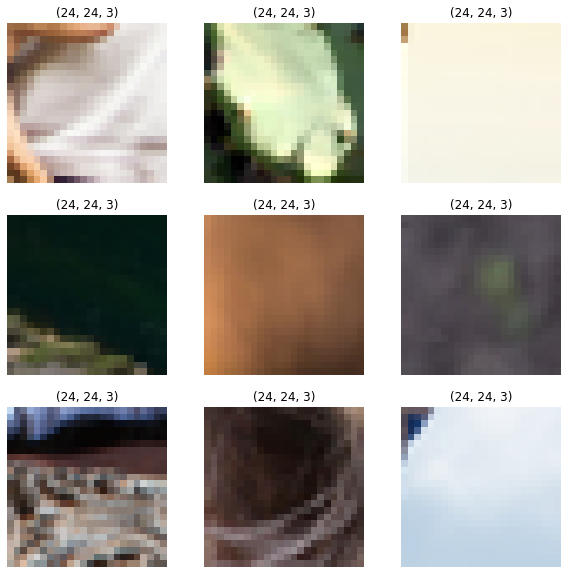

In [6]:
lr, hr = next(iter(ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lr[i].numpy().astype("uint8"))
    plt.title(lr[i].shape)
    plt.axis("off")

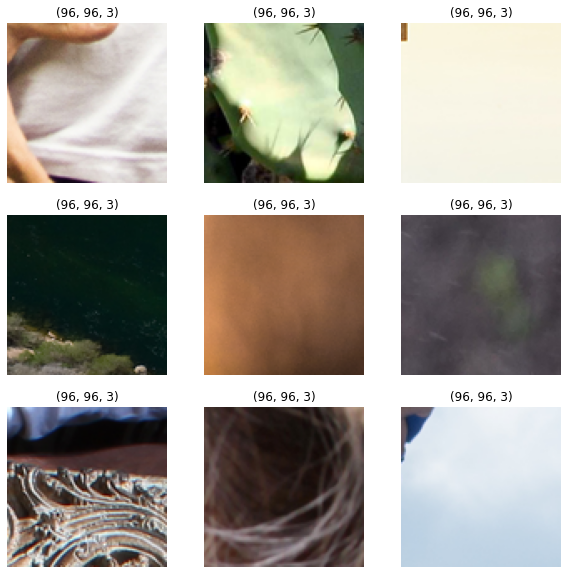

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hr[i].numpy().astype("uint8"))
    plt.title(hr[i].shape)
    plt.axis("off")

In [8]:
def normalize(x):
    return x / 255.0

def normalize2(x):
    return x / 127.5 - 1

def denormalize2(x):
    return (x + 1) * 127.5

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [9]:
def Upsampling(inputs):
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.Lambda(pixel_shuffle(scale=2))(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    return x

def ResBlock(inputs):
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.Add()([inputs, x])
    return x

def Generator(num_filters=64):
    input_layer = tf.keras.layers.Input(shape=(None, None, 3))
    x = tf.keras.layers.Lambda(normalize)(input_layer)
    x = tf.keras.layers.Conv2D(64, kernel_size=9, padding='same')(x)
    x = x_new = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    for _ in range(16):
        x = ResBlock(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x_new, x])

    x = Upsampling(x)
    x = Upsampling(x)

    x = tf.keras.layers.Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    output_layer = tf.keras.layers.Lambda(denormalize2)(x)

    return tf.keras.models.Model(input_layer, output_layer)


new_gen = Generator()
new_gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 15616       lambda[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, None, None, 6 64          conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
def Discriminator_block(inputs, num_filters, strides=1):
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x
    
def Discriminator(num_filters=64):
    input_layer = tf.keras.layers.Input(shape=(96, 96, 3))
    x = tf.keras.layers.Lambda(normalize2)(input_layer)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = Discriminator_block(x, 128)
    x = Discriminator_block(x, 256)
    x = Discriminator_block(x, 512)
    
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.models.Model(input_layer, output_layer)

In [11]:
new_disc = Discriminator()
new_disc.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0   

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=PiecewiseConstantDecay(boundaries=[10000], values=[1e-4, 1e-5]))
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=PiecewiseConstantDecay(boundaries=[10000], values=[1e-4, 1e-5]))

In [13]:
mse = tf.keras.losses.MeanSquaredError()
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [14]:
def discriminator_loss(fake_output, real_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy()
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy()
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def content_loss(content_model, sr, hr):
    mse = tf.keras.losses.MeanSquaredError()

    hr_feature = content_model(hr) / 12.75
    sr_feature = content_model(sr) / 12.75

    return mse(hr_feature, sr_feature)


def mse_based_loss(sr, hr):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(sr, hr)

def Content_Net(size=None, channels=3, i=5, j=4):
    vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(size, size, channels))
    block_name = 'block{}_conv{}'.format(i, j)
    model = tf.keras.Model(inputs=vgg19.input, outputs=vgg19.get_layer(block_name).output)
    return model

def PSNR(sr, hr):
    psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
    return psnr_value

In [15]:
content_model = Content_Net()

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
@tf.function
def train_step(low_res, high_res):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        low_res = tf.cast(low_res, tf.float32)
        high_res = tf.cast(high_res, tf.float32)

        SR = new_gen(low_res, training=True)

        HR_output = new_disc(high_res)
        SR_ouput = new_disc(SR)
        
        #Calculating PSNR Value of generated Image
        psnr_value = PSNR(high_res, SR)
        
        #Discriminator Loss
        loss_disc = discriminator_loss(SR_ouput, HR_output)

        #Generator Loss
        mse_loss = mse_based_loss(SR, high_res)
        gen_loss = generator_loss(SR_ouput)
        cont_loss = content_loss(content_model, SR, high_res)
        perceptual_loss = mse_loss + cont_loss + 1e-3 * gen_loss

    gen_grads = gen_tape.gradient(perceptual_loss, new_gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grads, new_gen.trainable_variables))

    disc_grads = disc_tape.gradient(loss_disc, new_disc.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_grads, new_disc.trainable_variables))

    return perceptual_loss, loss_disc, psnr_value

In [17]:
for epoch in range(250):

    for lr, hr in ds.take(1000):
        perceptual_loss, loss_disc, psnr_value = train_step(lr, hr)
        
    if epoch%50 == 0 or epoch==249:
        print(f'Epochs: {epoch}  Generator_Loss:{perceptual_loss:.3f}  PSNR:{psnr_value:.3f}')

2022-01-16 20:21:00.999545: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epochs: 0  Generator_Loss:291.242  PSNR:18.780
Epochs: 50  Generator_Loss:89.960  PSNR:30.011
Epochs: 100  Generator_Loss:111.662  PSNR:33.398
Epochs: 150  Generator_Loss:233.598  PSNR:25.957
Epochs: 200  Generator_Loss:103.983  PSNR:27.671
Epochs: 249  Generator_Loss:52.006  PSNR:29.389


In [18]:
new_gen.save("/kaggle/working/gen.h5")
new_gen.save("/kaggle/working/")

2022-01-17 04:53:36.597843: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
def Predict(model, img):
    sr = model(tf.cast(tf.expand_dims(img, axis=0), tf.float32))
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.squeeze(tf.cast(sr, tf.uint8),axis=0)
    return sr

def load_img(path):
    img = np.array(Image.open(path))
    return img

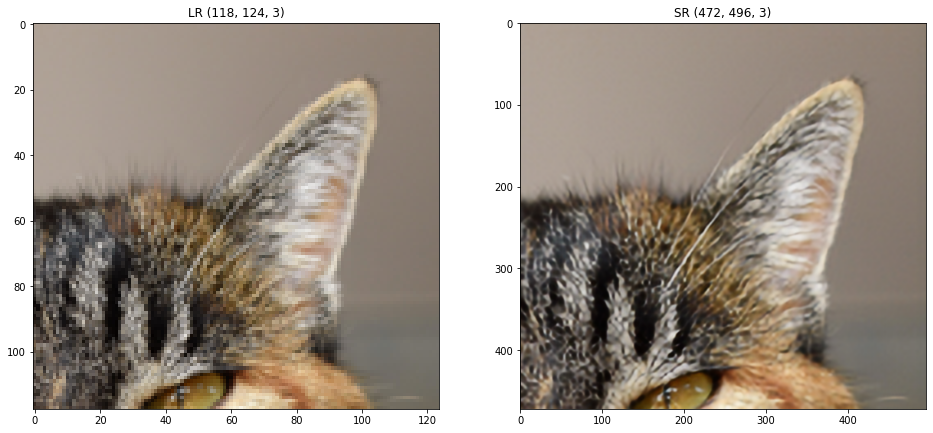

In [20]:
lr = load_img("../input/cat-and-bug/cat.png")
pred = Predict(new_gen, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()

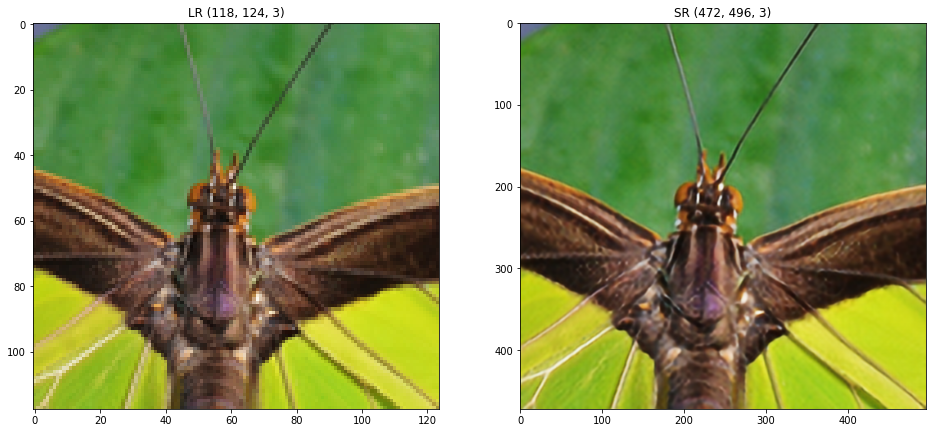

In [21]:
lr = load_img("../input/cat-and-bug/bug.png")
pred = Predict(new_gen, lr)

plt.figure(figsize=(16,9))
plt.subplot(121), plt.imshow(lr), plt.title(f"LR {lr.shape}")
plt.subplot(122), plt.imshow(pred), plt.title(f"SR {pred.shape}")
plt.show()